In [1]:
import os
import json
from google.cloud import storage
from tempfile import TemporaryFile

In [16]:
# gcloud settings
key_path = '../../credentials/gs-access-key.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_path
BUCKET = 'deep-musik-data'
JOB = 'docker_local_gs'
client = storage.Client()
bucket = client.bucket(BUCKET)

### Load data

In [17]:
# Load training data config used for the training job
config_blob = bucket.blob(f'trainer-output/{JOB}/train_config.json')
with TemporaryFile() as tmp:
    config_blob.download_to_file(tmp)
    tmp.seek(0)
    train_config = json.load(tmp)
train_config

{'data_config_id': 0, 'instruments': ['brass_electronic', 'string_electronic']}

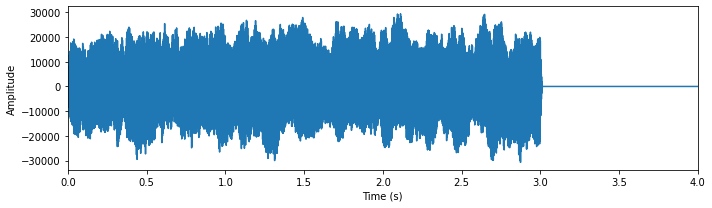

In [18]:
from audiolib import AudioDataset

ads = AudioDataset('../../data/raw/nsynth-train/')  # There is no string data in valid and test...
af = ads.load_file(instrument='string_electronic', file_index=0)
af.audio.plot()
af.audio.play()

### Preprocessing

In [20]:
# Load preprocessing config associated with the training data config
with open('../preprocessing/shell/data_configs.json') as f:
    data_configs = json.load(f)
data_config = data_configs[train_config['data_config_id']]['config']
data_config

{'start': 0.2,
 'end': 3,
 'time_intervals': 1,
 'resolution': 5,
 'exclude': ['fast_decay']}

/home/julian/projects/deep-music/src/evaluate/.venv/lib/python3.8/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


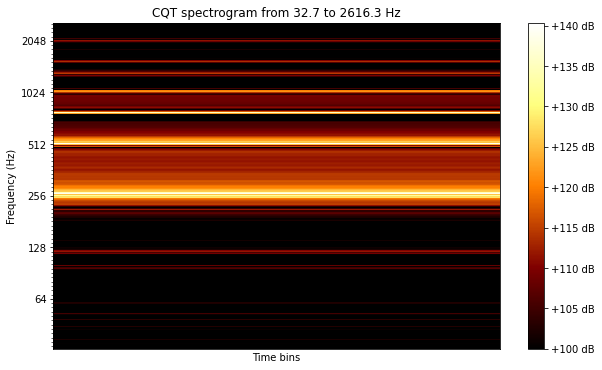

In [24]:
# Convert audio to spectrogram
from preprocessing.preprocess import PreProcessor

pp = PreProcessor(data_config)

_, spec = pp.audio_to_spectrogram(('', af.audio))
spec.plot(db_thresh=100)

In [26]:
# Load the normalisation parameters used for the training data
norm_blob = bucket.blob(f'trainer-output/{JOB}/norm_params.json')
with TemporaryFile() as tmp:
    norm_blob.download_to_file(tmp)
    tmp.seek(0)
    norm_params = json.load(tmp)
norm_params

{'mean': 232174.1014709981, 'std': 749005.8619992567}

In [27]:
import numpy as np
from trainer.dataset import ToTensor, Normalise

norm = Normalise(norm_params['mean'], norm_params['std'])
tensor = ToTensor(float32=True)

spec_norm = tensor(norm(np.abs(spec).reshape(1, 1, -1)))

### Model scoring

In [29]:
import torch
from trainer.model import MusicNet

# Download model from gcloud
model_blob = bucket.blob(f'trainer-output/{JOB}/model.pt')
with TemporaryFile() as tmp:
    model_blob.download_to_file(tmp)
    tmp.seek(0)
    state_dict = torch.load(tmp)

# Create model with state_dict weights
model = MusicNet()
model.load_state_dict(state_dict)
model

MusicNet(
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=3712, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

In [30]:
# Predictions
with torch.no_grad():
    label_proba = torch.exp(model.forward(spec_norm))
    label_numeric = torch.argmax(label_proba)
    label = train_config['instruments'][label_numeric]
    print(f'{label} ({100*torch.max(label_proba).numpy():.2f} %)')

string_electronic (51.32 %)
